# Week 4 HW part 1:  loading NASA weblogs into RDDs

During lecture we hand-generated tiny amounts of data (e.g. `[5, 3, 65, 2]`) on the driver (this notebook) and then pushed that data out to the workers using `parallelize()`.  This created an RDD.

In this homework we will create an RDD in a different way:  the workers will read data by themselves from NASA weblog files that you already downloaded to the local filesystem.

In [1]:
from pyspark import SparkContext
sc = SparkContext('local', 'weblog_analysis')

Using the `textFile()` function, we can tell spark to read files into an RDD (each line becomes a separate element in the RDD).

Remember that the NASA weblogs are compressed (gzipped).  Spark is smart enough to detect this and decompress automatically for us.

Also, using a wildcard pattern `*`, we can read in many files at once.

In [2]:
logs_rdd = sc.textFile('NASA_access_log_*.gz')

Let's have a look at a few of the records

In [3]:
logs_rdd.take(5)

['in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839',
 'uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0',
 'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0',
 'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0',
 'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0" 304 0']

In [4]:
# We didn't specify the number of partitions, so let's see what Spark defaults to
logs_rdd.getNumPartitions()

2

Write code to determine how many log lines are in the files altogether.

In [15]:
# How many lines are in this file?  Do you think this is this an ACTION, or a TRANSFORMATION?
num_lines = logs_rdd.count() #This is an action since it takes rdd and return one number in driver.
#raise NotImplementedError()

In [16]:
assert num_lines == 3461613

Write code that creates a new RDD containing the *lengths* of the lines.  For example, if `logs_rdd` looked like this:
```
['this',
 'is',
 'getting',
 'more',
 'challenging',
 ...]
```
then the new RDD `line_lengths_rdd` would look like this:
```
[4,
 2,
 7,
 4,
 11,
 ...]
```

In [36]:
# NOTE: the assert that tests this cell is a few cells down
line_lengths_rdd = logs_rdd.map(lambda x: len(x))
#raise NotImplementedError()

We will reuse `line_lengths_rdd` again, so let's instruct Spark to cache (remember) it.  This way it doesn't need to be recomputed in the future.

If we don't do this then, after the *action* is taken, there is no guarantee that Spark will bother to remember the RDD that you computed (Spark starts cleaning up to free up some memory for future computations).

In [37]:
line_lengths_rdd.persist()

PythonRDD[20] at RDD at PythonRDD.scala:53

In [38]:
assert line_lengths_rdd.take(5) == [122, 71, 96, 98, 95]

Use `.reduce()` to compute the total number of characters in the dataset

In [42]:
total_chars = line_lengths_rdd.reduce(lambda x,y: x+y)
#raise NotImplementedError()

In [43]:
assert total_chars == 369594520

### Plotting line lengths

It is time to learn a little about graphing.  There are several popular graphing libraries for Python.  The oldest, and still most used, is `matplotlib`.  A tutorial can be found here:

https://pythonprogramming.net/bar-chart-histogram-matplotlib-tutorial/

Below we will plot a histogram of line lengths.  Admittedly this isn't very useful, but we're not ready to parse the logs to extract more interesting insights yet (that will be your Exam 1).

Make sure that your histogram looks reasonably professional - it needs to have labeled axes and a title.

But first, we need to subsample!

#### Subsampling

We saw above that there are over 3 million lines of logs.  For the purposes of plotting we should subsample
using the `.sample()` transformation.

This tutorial describes some of the most common transformations and actions, including `.sample()`:
    
https://www.analyticsvidhya.com/blog/2016/10/using-pyspark-to-perform-transformations-and-actions-on-rdd/

Collect a sample (**with replacement**) of about 5000 line lengths into a new RDD:

#### Note for the link:
#1 The __“flatMap”__ transformation will return a new RDD by first applying a function to all elements of this RDD, and then flattening the results. This is the main difference between the “flatMap” and map transformations.
#2 To remove the stop words, we can use a __“filter”__ transformation which will return a new RDD containing only the elements that satisfy given condition(s).
#3 The __“groupBy”__  transformation will group the data in the original RDD. It creates a set of key value pairs, where the key is output of a user function, and the value is all items for which the function yields this key.
#4 We can apply the __“groupByKey” / “reduceByKey”__ transformations on (key,val) pair RDD. The “groupByKey” will group the values for each key in the original RDD. It will create a new pair, where the original key corresponds to this collected group of values.
#5 


In [65]:
sample_fraction = 5000/num_lines

seed = 2343243  # We will fixed the seed so that you get the same random sample that I get.

# EXPLANATION:  there is no such thing as a true random number generator.  
# Algorithms are deterministic.
# However, if you know enough about Number Theory then you can design an algorithm 
# that "looks" random.
# These types of algorithms are called "pseudorandom".

# All pseudorandom algorithms need to start somewhere (an initial number, or "seed").
# Given the same seed, the pseudorandom algorithm will always produce the same sequence
# of "random" numbers (no matter how many times it is run).

# In a real analysis the seed should be as random as possible, and is automatically 
# gathered in the beginning by the algorithm using random input from the
# outside world (e.g. last 10 keystrokes, current timestamp, etc).


sample_line_lengths_rdd = line_lengths_rdd.sample(True, sample_fraction, seed)
#raise NotImplementedError()

In [66]:
assert sample_line_lengths_rdd.take(5) == [86, 135, 104, 124, 103]

Now use a `.collect()` action to pull the 5000 samples back to the driver and plot them in a histogram:

In [67]:
line_lengths = sample_line_lengths_rdd.collect()

Text(0.5,1,'Line Lengths Frequency \n5000 Sample Logs Lines')

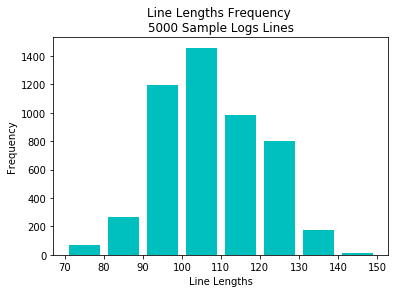

In [84]:
import matplotlib.pyplot as plt
import seaborn  # seaborn just makes plots look a little nicer

# plot `line_lengths` in a histogram here
bins = [70,80,90,100,110,120,130, 140, 150]

plt.hist(line_lengths, bins, histtype='bar', rwidth= 0.8, color = "c")
plt.xlabel('Line Lengths')
plt.ylabel('Frequency')
plt.title('Line Lengths Frequency \n5000 Sample Logs Lines')

#raise NotImplementedError()